In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame
import pandas as pd
import numpy as np
import torch
from chronos import BaseChronosPipeline
from models import predict_chronos
from chronos import BaseChronosPipeline
from tqdm import tqdm
from timeseries import PredictionLeadTime, PredictionLeadTimes, TabularDataFrame

/Users/louisskowronek/Documents/thesis/master-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# read in data. Here only using data from 2021-2025 for first tests
df = pd.read_csv("data/Realisierter_Stromverbrauch_202103010000_202503270000_Stunde.csv", thousands=".", decimal=",", sep=";")

# bring data in right shape
for col in df.columns[2:]:
    df[col] = df[col].str.replace('.', '')
    df[col] = df[col].str.replace(',', '.').replace("-",np.nan).astype(float)
df = df[["Datum von", "Netzlast [MWh] Berechnete Auflösungen"]].copy()
df = df.rename(columns={"Datum von":"timestamp", "Netzlast [MWh] Berechnete Auflösungen": "target"})
df["item_id"] = 0 
df["timestamp"] = pd.to_datetime(df["timestamp"], dayfirst=True)
df = df.drop_duplicates(subset=["item_id","timestamp"], keep="first")

In [5]:
df.tail(20)

,timestamp,target,item_id
35668,2025-03-26 04:00:00,46351.50,0
35669,2025-03-26 05:00:00,49857.25,0
35670,2025-03-26 06:00:00,56725.50,0
35671,2025-03-26 07:00:00,60778.00,0
35672,2025-03-26 08:00:00,63646.00,0
35673,2025-03-26 09:00:00,64506.75,0
35674,2025-03-26 10:00:00,65507.25,0
35675,2025-03-26 11:00:00,66186.00,0
35676,2025-03-26 12:00:00,65441.00,0
35677,2025-03-26 13:00:00,64230.50,0


In [6]:
# create TimesSeriesDataFrame
data = TimeSeriesDataFrame(df)
# split data in train and test
data_train, data_test = data.split_by_time(pd.Timestamp("01-01-2023"))

# Chronos Bolt Zero Shot

In [8]:
# load model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-tiny", # could also use e.g. "amazon/chronos-bolt-small", "amazon/chronos-bolt-base", "amazon/chronos-bolt-large"
    device_map="mps", # mps for using mac gpu
)

In [9]:
predictions_raw = predict_chronos(pipeline=pipeline, 
                                  data=data_test, 
                                  lead_times=np.arange(1,65),
                                  freq=pd.Timedelta("1h"))

100%|██████████| 306/306 [00:12<00:00, 24.37it/s]


In [16]:
# calculate crps for all lead times (1 to 64)
predictions_raw.get_crps()

{1: 614.4922082008098,
 2: 747.6605021673224,
 3: 837.1297197573348,
 4: 913.5434796784774,
 5: 970.9978606360938,
 6: 1020.2504691341857,
 7: 1061.9064708492872,
 8: 1088.654438207666,
 9: 1118.0452493108444,
 10: 1149.7327961767571,
 11: 1173.0910850823134,
 12: 1196.759311830442,
 13: 1214.3868745828363,
 14: 1235.7120379706735,
 15: 1249.3958284853063,
 16: 1256.0256565952338,
 17: 1267.980736655843,
 18: 1280.3071609953408,
 19: 1285.3103992154383,
 20: 1293.3891583714596,
 21: 1293.561713728224,
 22: 1299.0475025907137,
 23: 1309.4899926945686,
 24: 1321.525632761391,
 25: 1354.2864667381255,
 26: 1382.3296481179798,
 27: 1407.232484317177,
 28: 1432.1941530002875,
 29: 1453.2372872633189,
 30: 1471.4694895959478,
 31: 1479.1360729894266,
 32: 1482.3636916406886,
 33: 1486.815754035525,
 34: 1490.7739028020349,
 35: 1499.8664466502598,
 36: 1502.7350481840367,
 37: 1502.666816012568,
 38: 1510.8839419275942,
 39: 1516.4980372616867,
 40: 1522.6769087009804,
 41: 1525.330555365340

In [ ]:
# alternatively only get results for certain lead times (in h)
predictions_raw.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 614.4922082008098,
 12: 1196.759311830442,
 24: 1321.525632761391,
 32: 1482.3636916406886,
 48: 1542.8868614432174,
 64: 1703.8207140067298}

In [18]:
# get empirical coverage rates
predictions_raw.get_empirical_coverage_rates([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,0.025789,0.080125,0.077673,0.081248,0.089981,0.096109
0.2,0.097487,0.174599,0.177255,0.163262,0.179144,0.174037
0.3,0.201818,0.263967,0.278317,0.248749,0.272853,0.257379
0.4,0.323818,0.358952,0.376826,0.337861,0.370187,0.347360
0.5,0.463283,0.457614,0.466193,0.427740,0.466653,0.443009
0.6,0.608773,0.559544,0.566796,0.520887,0.563017,0.542794
0.7,0.752426,0.671586,0.667756,0.623634,0.662905,0.650087
0.8,0.878919,0.789194,0.780360,0.737872,0.768818,0.758554
0.9,0.971862,0.910888,0.907875,0.876162,0.895567,0.883158


<Figure size 800x800 with 0 Axes>

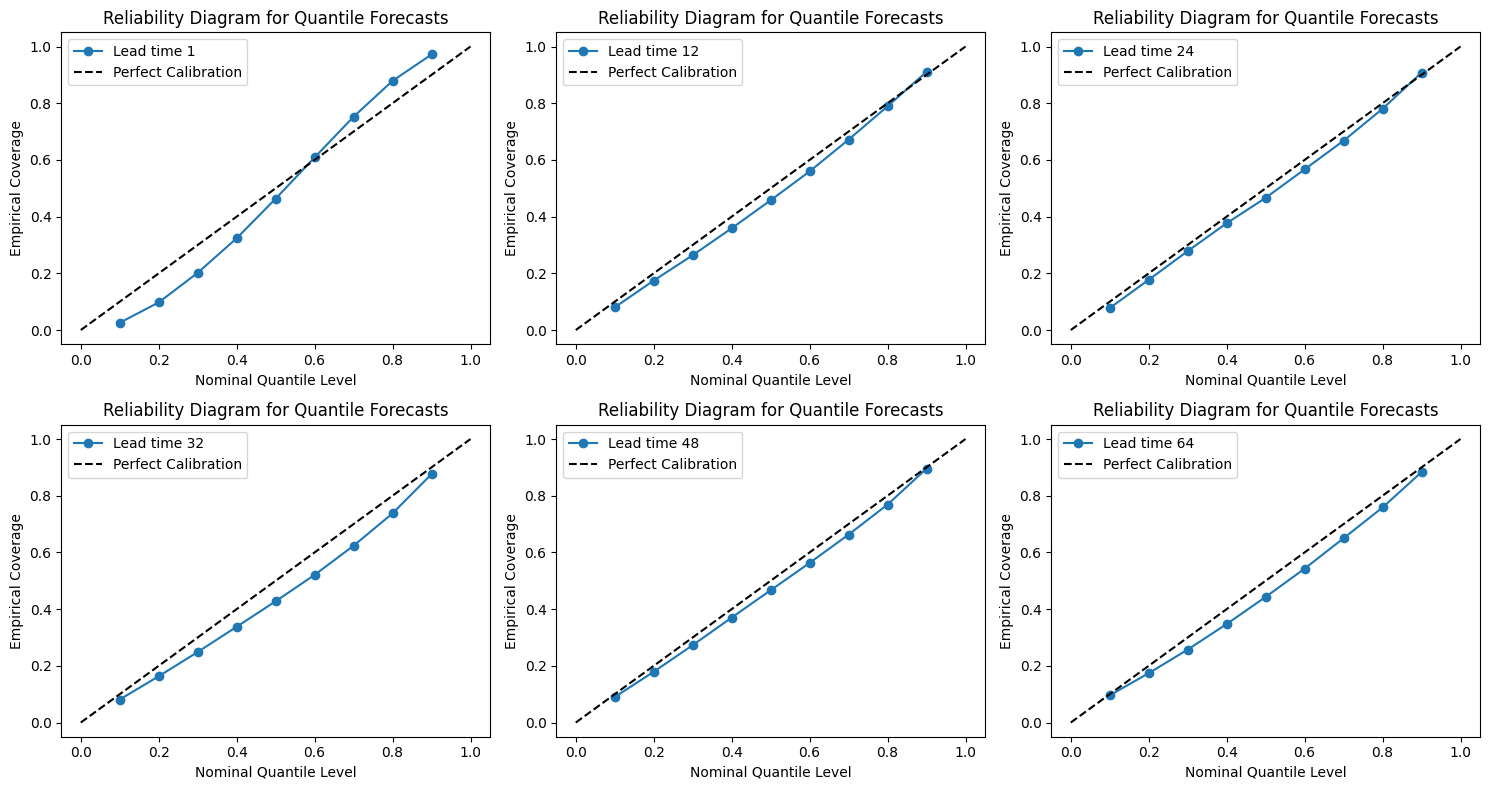

In [19]:
# plot reliability diagrams
predictions_raw.get_reliability_diagram([1, 12, 24, 32, 48, 64])

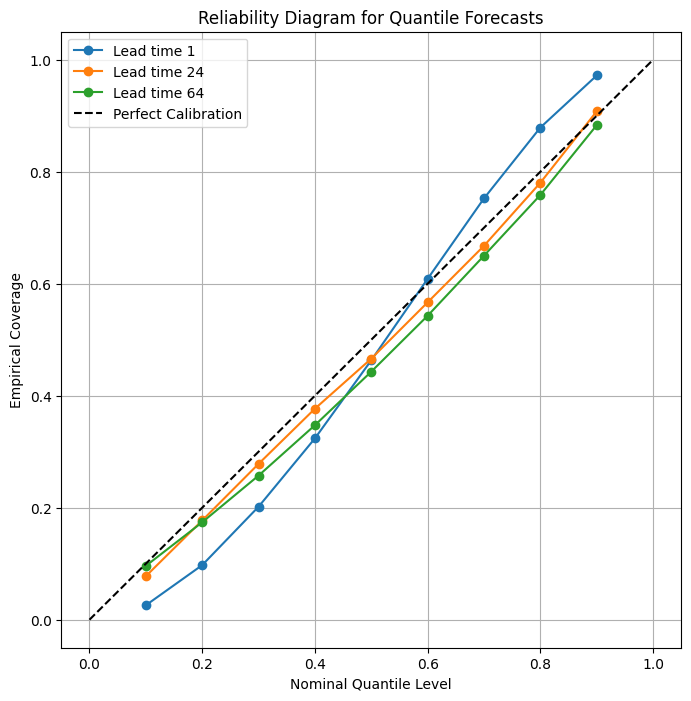

In [20]:
# use overlay
predictions_raw.get_reliability_diagram([1, 24, 64], overlay=True)

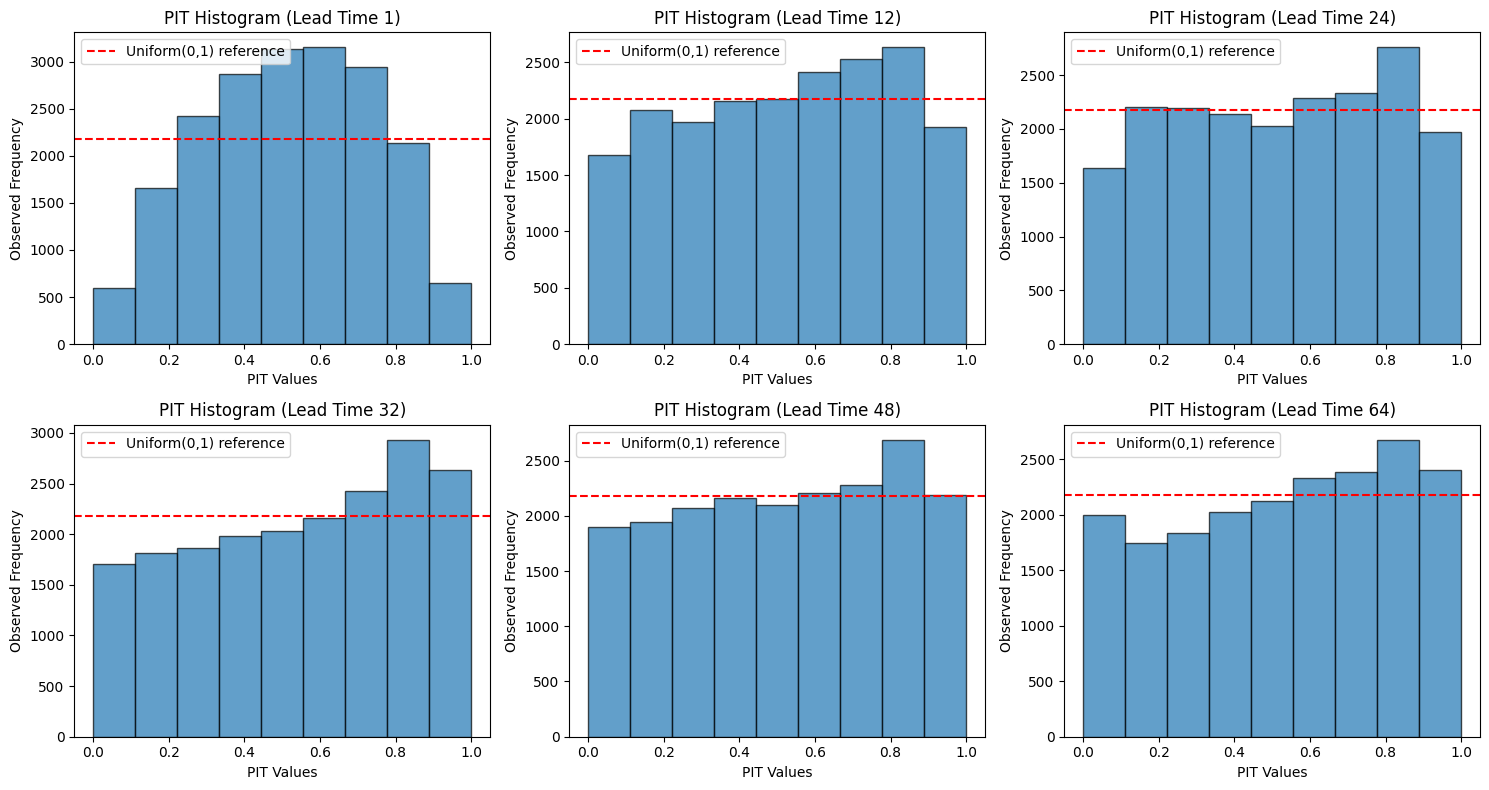

In [21]:
# plot PIT histograms
predictions_raw.get_pit_histogram([1, 12, 24, 32, 48, 64])

In [ ]:
# plot random subset of the predictions
predictions_raw.results[1].get_random_plot()

# Postprocessing

## Parametric Approximation of Log-Normal Distribution
- (V1) Fitte Normalverteilung für log Y, mit folgender Parametrisierung: mean = a + b*M, wobei M = Median-Vorhersage des Modells für log Y. Standardabweichung = c + d*IQR, wobei IQR = Interquartilsabstand (z.B. 90%-10%) des Modells für log Y. Falls sich die Modellvorhersagen anfangs auf Y (statt log Y) beziehen kannst Du die einfach logarithmieren, das ist einer der Vorteile von Quantilen.

In [16]:
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

In [14]:
# get zero shot predictions on training dataset
predictions_train = predict_chronos(pipeline=pipeline, 
                                    data=data_train, 
                                    lead_times=np.arange(1,65),
                                    freq=pd.Timedelta("1h"))

100%|██████████| 252/252 [00:10<00:00, 25.12it/s]


check if data is normally distributed

In [143]:
# get target variable
log_target = np.log(predictions_train.results[1].data["target"])

<Axes: >

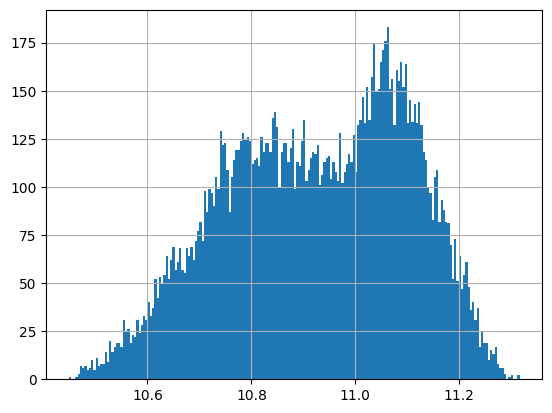

In [144]:
# plot histogram of target variable
log_target.hist(bins=200)

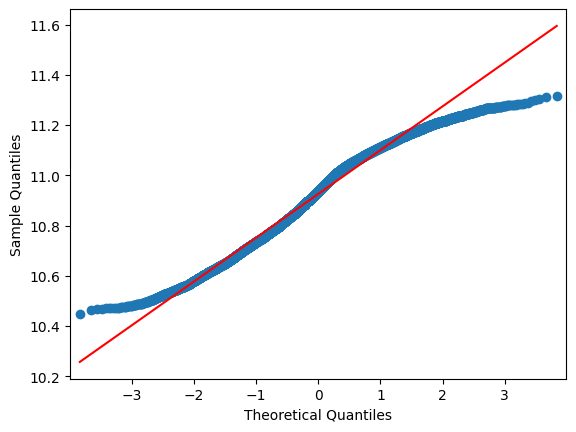

In [139]:
# q-q plot
qqplot(log_target, line='s')
plt.show()

In [ ]:
# normality test
# The D’Agostino and Pearson’s test calculates summary statistics from the data, namely kurtosis and skewness, 
# to determine if the data distribution departs from the normal distribution.
stat, p = normaltest(log_target)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=1638.543, p=0.000
Sample does not look Gaussian (reject H0)


"Netzlast [MWh]" does not seem to be normally distributed. Still implement post-processing method since we haven't decided on the actual time series.

In [ ]:
# maximum likelihood

In [17]:
freq = pd.Timedelta("1h")
lead_time = list(predictions_raw.results.keys())
results_nrml = {}

for lt in lead_time:
    # estimate mean and std (a, b, c, d) with linear regression using train data
    
    prediction_train = predictions_train.results[lt]
    quantile_levels = predictions_train.results[lt].quantiles
    
    df_train = prediction_train.to_dataframe().dropna().copy()
    # TODO: make this nicer. Discard the first 100 entries 
    df_train = df_train.iloc[100:].copy()
    log_df_train = np.log(df_train[quantile_levels + ["target"]])

    # estimate mean=a+b*Median
    x_mu = sm.add_constant(log_df_train[0.5])
    y_mu = log_df_train["target"] 
    model_mu = sm.OLS(y_mu, x_mu).fit()
    # a, b = model_mu.params

    # calculate std deviation of log Y based on expanding window
    #log_df_train["std_target"] = log_df_train["target"].groupby("item_id").expanding(min_periods=100).std().droplevel(0)
    log_df_train["std_target"] = log_df_train["target"].groupby("item_id").rolling(100, min_periods=100).std().droplevel(0)

    log_df_train = log_df_train.dropna()
    iqr = log_df_train[0.9]-log_df_train[0.1]
    x_sigma = sm.add_constant(iqr)
    y_sigma = log_df_train["std_target"]
    model_sigma = sm.OLS(y_sigma, x_sigma).fit()
    # c, d = model_sigma.params

    # test performance
    df_test = predictions_raw.results[lt].to_dataframe().copy()
    # TODO: make this nicer
    df_test = df_test.iloc[100:]
    log_pred_test = np.log(df_test[quantile_levels + ["target"]])

    x_mu = sm.add_constant(log_pred_test[0.5])
    mean_est = model_mu.predict(x_mu)

    iqr = log_pred_test[0.9]-log_pred_test[0.1]
    x_sigma = sm.add_constant(iqr)
    std_est = model_sigma.predict(x_sigma)

    log_predictions = norm.ppf(np.array(quantile_levels).reshape(-1,1), loc=mean_est, scale=std_est).T
    predictions = np.exp(log_predictions)

    results_nrml[lt] = PredictionLeadTime(lead_time=lt,
                                        predictions=torch.tensor(predictions),
                                        quantiles=quantile_levels,
                                        freq=predictions_raw.results[lt].freq,
                                        data=predictions_raw.results[lt].data.iloc[100:])


predictions_nrml = PredictionLeadTimes(results=results_nrml)

In [18]:
predictions_nrml.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 2106.1483284536116,
 12: 2305.6656562721987,
 24: 2363.123576550525,
 32: 2417.4431345103017,
 48: 2456.6808955068923,
 64: 2521.5824604335417}

<Figure size 800x800 with 0 Axes>

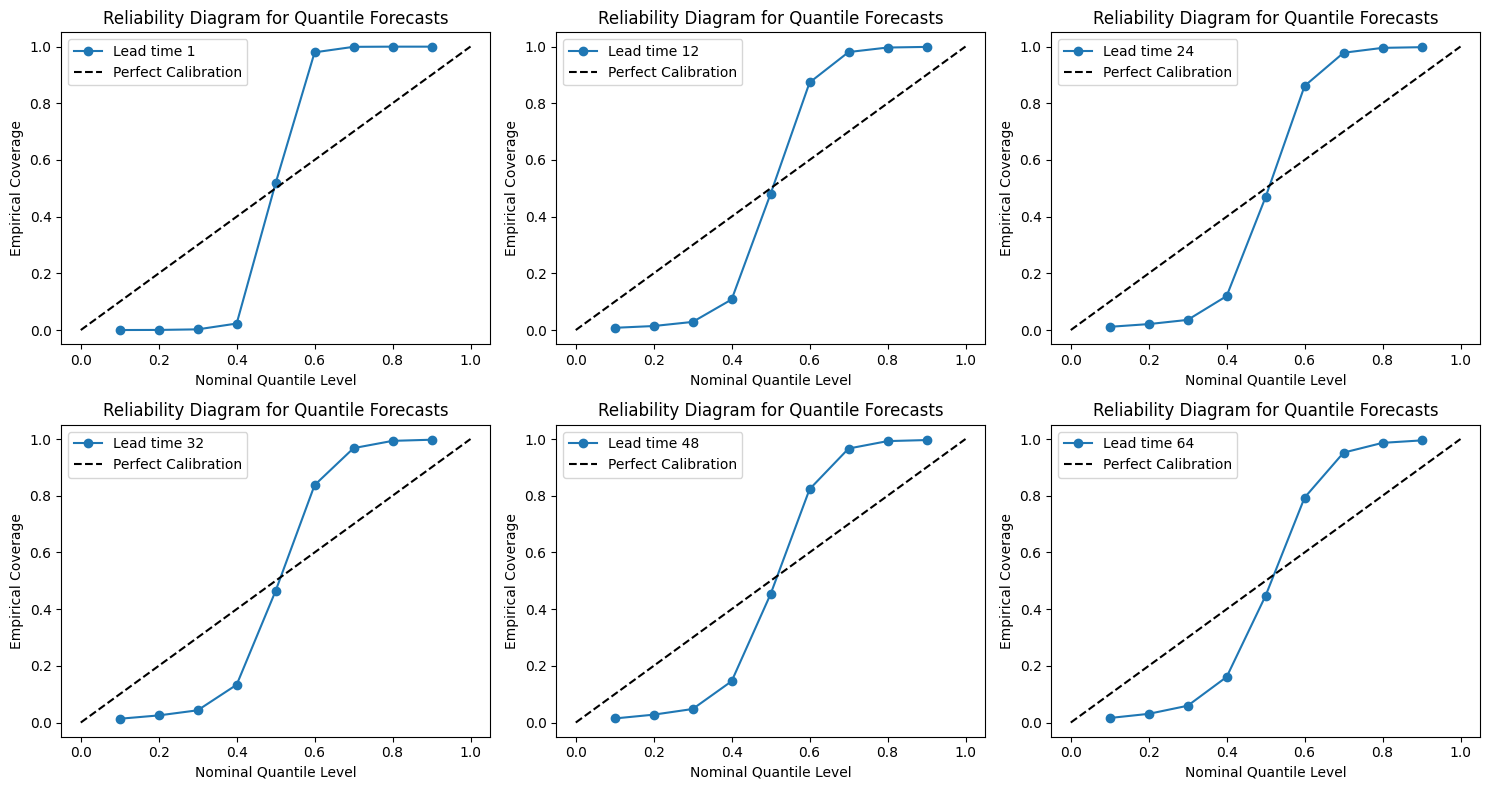

In [ ]:
predictions_nrml.get_reliability_diagram(lead_times=[1, 12, 24, 32, 48, 64])

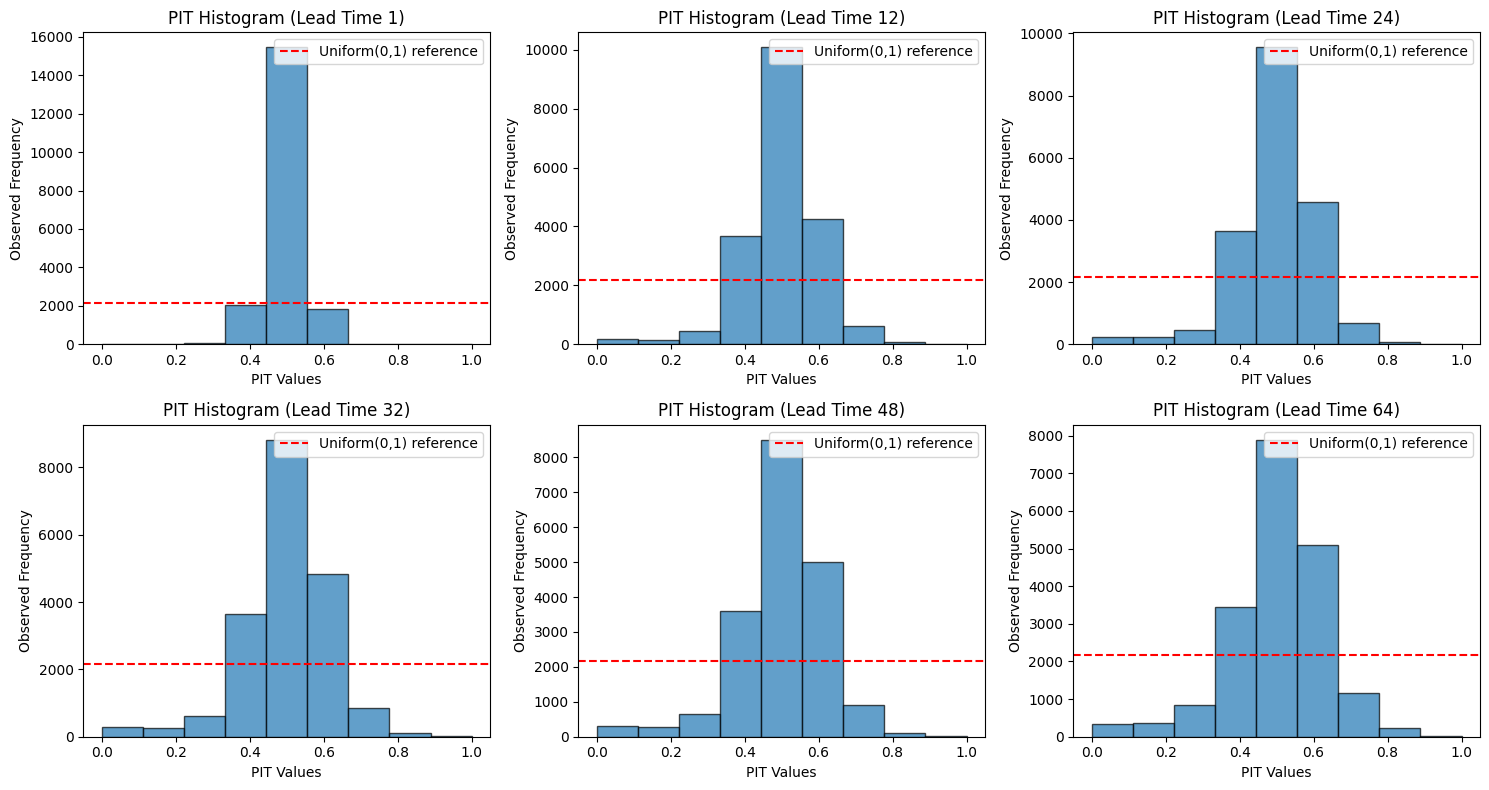

In [128]:
predictions_nrml.get_pit_histogram(lead_times=[1, 12, 24, 32, 48, 64])

In [ ]:
# plot a random part of the predictions
predictions_nrml.results[1].get_random_plot()

## Quantile Regression

-  (V2) Fitte separate Quantilsregression für jedes Quantil (z.B. 10%, 20%, ..., 90%). D.h. für jedes Level eine Quantilsregression mit Konstante und einem Regressor (= Quantils-Vorhersage des Modells). Der Spezialfall mit Konstante = 0 und Slope = 1 würde dann heißen, dass die Vorhersagen bereits perfekt kalibriert sind.



In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [10]:
# get zero shot predictions on training dataset
predictions_train = predict_chronos(pipeline=pipeline, 
                                    data=data_train, 
                                    lead_times=np.arange(1,65),
                                    freq=pd.Timedelta("1h"))

100%|██████████| 252/252 [00:10<00:00, 24.60it/s]


In [ ]:
freq = pd.Timedelta("1h")
lead_time = list(predictions_raw.results.keys())
results_qr = {}

for lt in tqdm(lead_time):
    
    quantiles = predictions_raw.results[lt].quantiles

    # prepare predictions for postprocessing
    prediction_test = predictions_raw.results[lt].to_dataframe().dropna()
    prediction_train = predictions_train.results[lt].to_dataframe().dropna()
    cols_rename = {q: f"feature_{q}" for q in quantiles}
    prediction_test = prediction_test.rename(columns=cols_rename)
    prediction_train = prediction_train.rename(columns=cols_rename)
    cols_to_keep = list(cols_rename.values()) + ["target"]
    train_data = TabularDataFrame(prediction_train[cols_to_keep])
    test_data = TabularDataFrame(prediction_test[cols_to_keep])

    # store results
    qr_models = {}
    test_results = {}

    # x_scalar = StandardScaler()
    # y_scalar = StandardScaler()

    # fit a quantile regression for each quantile and make predictions on test dataset
    for q in quantiles:

        x_train = np.log(train_data[f"feature_{q}"].values.reshape(-1, 1))
        y_train = np.log(train_data["target"].values)
        x_test = np.log(test_data[f"feature_{q}"].values.reshape(-1, 1))
        y_test = np.log(test_data["target"].values)

        # x_train = x_scalar.fit_transform(train_data[f"feature_{q}"].values.reshape(-1, 1))
        # y_train = y_scalar.fit_transform(train_data["target"].values.reshape(-1, 1))
        # x_test = x_scalar.transform(test_data[f"feature_{q}"].values.reshape(-1, 1))
        # y_test = test_data["target"].values

        # Add constant for intercept
        x_train = sm.add_constant(x_train)
        x_test = sm.add_constant(x_test)

        # Fit quantile regression model
        model = sm.QuantReg(y_train, x_train)
        qr_models[q] = model.fit(q=q, max_iter=2000)

        # Predict on test data
        predictions = qr_models[q].predict(x_test)
        test_results[q] = np.exp(predictions)
        # test_results[q] = y_scalar.inverse_transform(predictions.reshape(-1, 1)).flatten()

    results_qr[lt] = PredictionLeadTime(lead_time=lt,
                                        predictions=torch.tensor(np.array(list(test_results.values())).T),
                                        freq=freq,
                                        data=test_data)

predictions_qr = PredictionLeadTimes(results=results_qr)

100%|██████████| 64/64 [16:54<00:00, 15.86s/it]


In [20]:
predictions_qr.get_crps(lead_times=[1, 12, 24, 32, 48, 64])

{1: 572.8291456751732,
 12: 1200.3277977859573,
 24: 1325.1823738078374,
 32: 1485.5192253277091,
 48: 1566.2867076813682,
 64: 1734.2212986210545}

In [21]:
predictions_qr.get_quantile_scores([1, 12, 24, 32, 48, 64])

,1,12,24,32,48,64
0.1,173.823520,406.500518,494.206876,595.164422,658.710050,759.149611
0.2,267.195946,571.696324,659.880399,754.152060,796.629637,902.591879
0.3,325.472769,678.111601,763.182374,855.616348,901.357613,990.291928
0.4,355.196773,736.018985,813.819333,906.163233,951.167708,1045.990724
0.5,363.515879,754.461962,823.615440,913.614739,955.762398,1043.955546
0.6,350.455500,728.185462,790.473425,868.730664,912.331036,996.424514
0.7,317.518231,657.414668,705.534057,774.225531,812.980224,887.578335
0.8,258.768353,533.256639,558.985266,623.993159,652.728168,714.836726
0.9,165.784184,335.828930,353.623511,393.176356,406.623350,463.176581


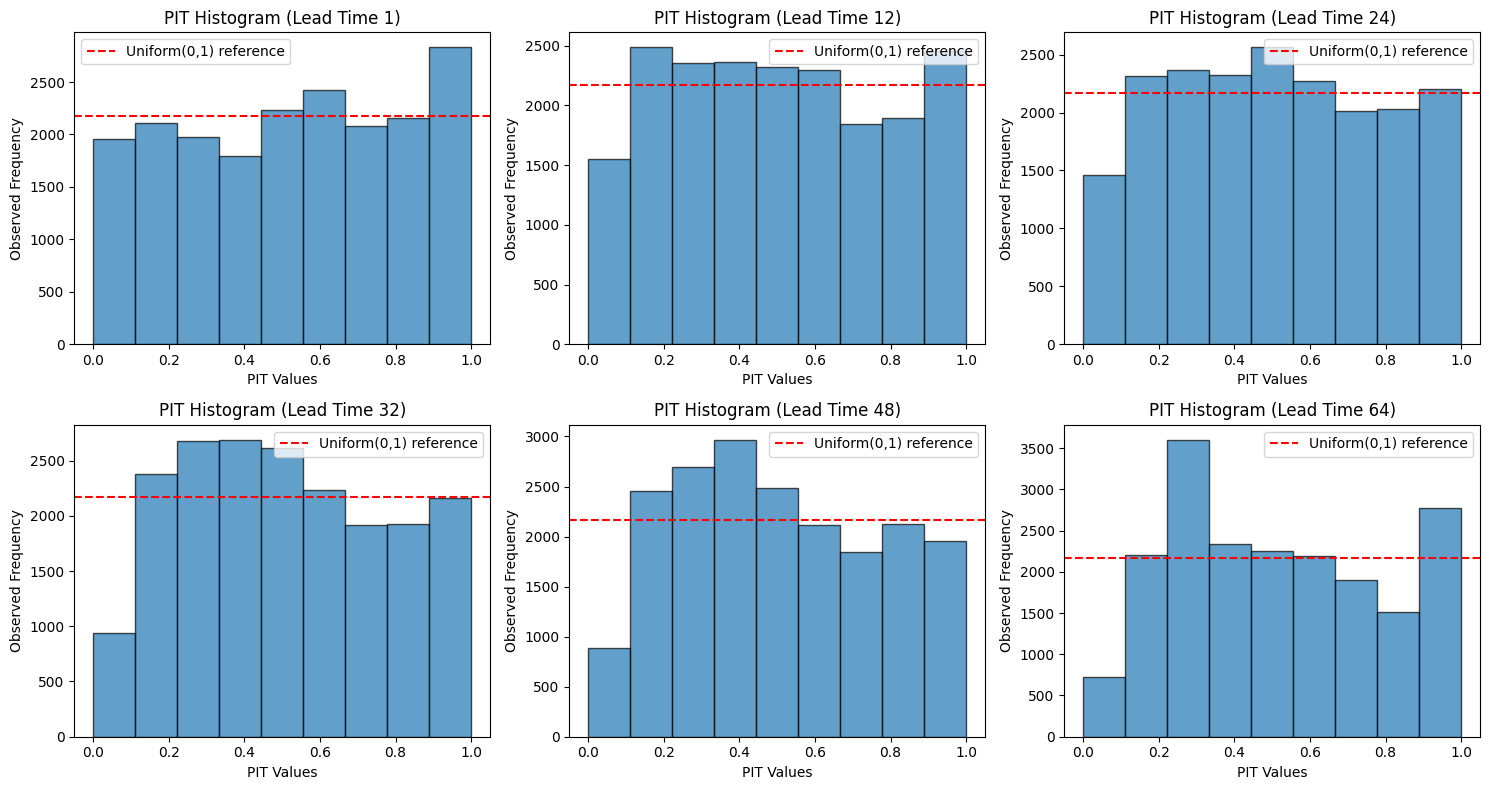

In [22]:
predictions_qr.get_pit_histogram([1, 12, 24, 32, 48, 64])

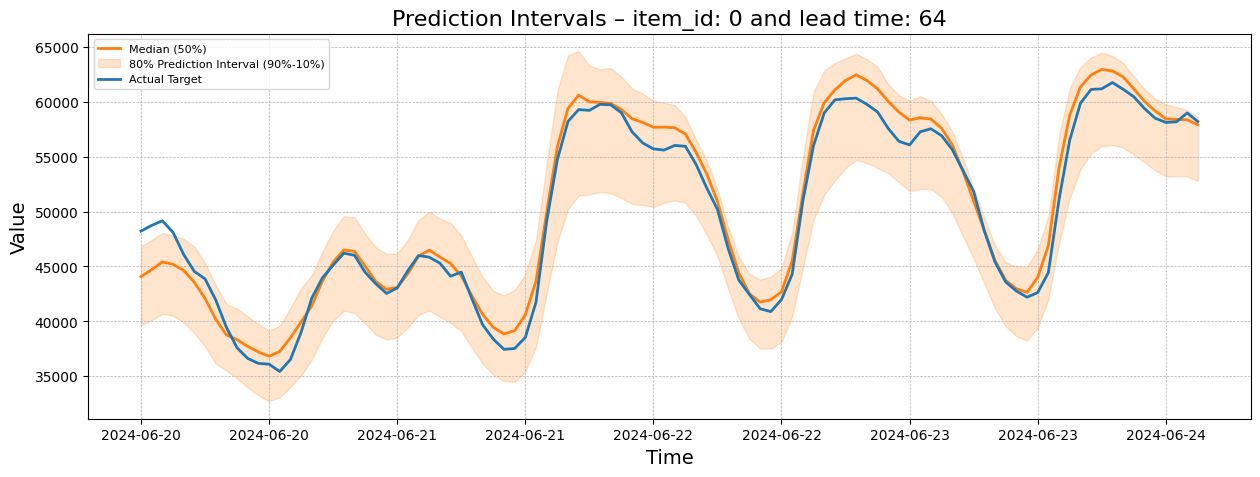

In [58]:
predictions_qr.results[64].get_random_plot()